In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/OCT2017_dataset.zip' -d '/content' &> /dev/null

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd

import glob
from itertools import repeat
from itertools import product

from keras import layers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import Callback
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore")

In [4]:
# Data path
TRAIN_PATH = r'/content/OCT2017/train/'
VAL_PATH = r'/content/OCT2017/val/'
TEST_PATH = r'/content/OCT2017/test/'

# Parameters
CLASSES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
NUM_CLASSES = len(CLASSES)
IMG_DIMS = 224
IMG_SHAPE = (IMG_DIMS, IMG_DIMS, 3)

FE_EPOCHS = 30    # feature extraction epochs
FT_EPOCHS = 10    # fine tuning epochs

BATCH_SIZE = 128

The size of  df_train_CNV  is (37205, 2) 
The size of  df_train_DME  is (11348, 2) 
The size of  df_train_DRUSEN  is (8616, 2) 
The size of  df_train_NORMAL  is (26315, 2) 


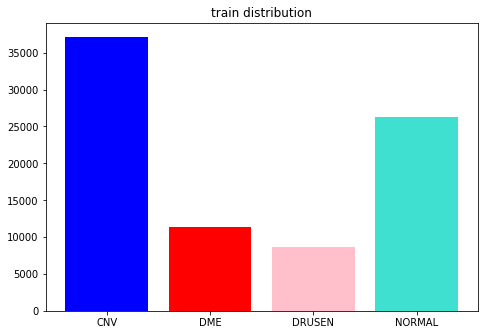

The size of  df_val_CNV  is (8, 2) 
The size of  df_val_DME  is (8, 2) 
The size of  df_val_DRUSEN  is (8, 2) 
The size of  df_val_NORMAL  is (8, 2) 


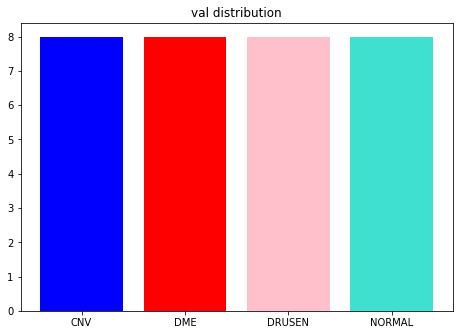

The size of  df_test_CNV  is (242, 2) 
The size of  df_test_DME  is (242, 2) 
The size of  df_test_DRUSEN  is (242, 2) 
The size of  df_test_NORMAL  is (242, 2) 


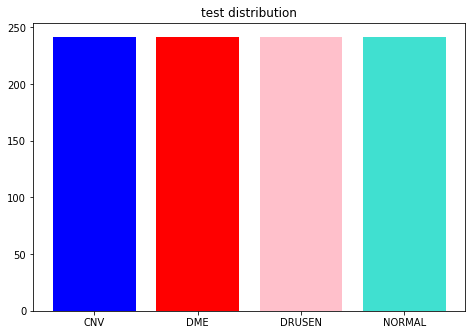

In [5]:
# load data, plot class distribution

def load_data(path, label, class_type):
    
    image_list = glob.glob(path + class_type + '/*')
    label_list = list(repeat(label, len(image_list)))
    
    data = list(zip(image_list,label_list))
    df = pd.DataFrame(data, columns = ['images', 'labels'])

    return df
        

def plot_dataset_imbalance(sample_distribution, title): 
    colors = ['blue', 'red', 'pink', 'turquoise']
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(CLASSES, sample_distribution, color=colors)
    plt.title(title + ' distribution')
    plt.show()
        
        
        
for dataset, path in list(zip(['train', 'val', 'test'], [TRAIN_PATH, VAL_PATH, TEST_PATH])):
  
    for label,class_type in enumerate(CLASSES):
        df_var = "df_" + dataset + "_" + class_type
        vars()[df_var] = load_data(path, str(label), class_type)
        sample_size_var = "num_" + class_type
        vars()[sample_size_var] = vars()[df_var].shape[0]        
        print('The size of ', df_var, ' is {} '.format(vars()[df_var].shape))
    
    sample_distribution = [num_CNV, num_DME, num_DRUSEN, num_NORMAL]
    plot_dataset_imbalance(sample_distribution, dataset)

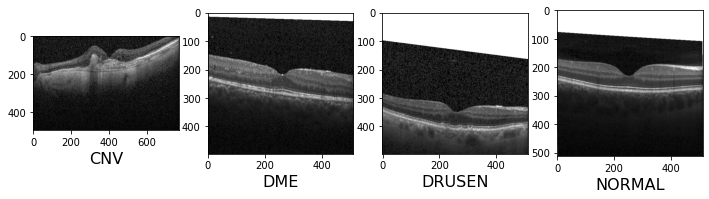

In [6]:
# plot randomly selected images of each class

fig=plt.figure(figsize=(12, 10))
cols = 4
rows = 1

for idx, rand_idx in enumerate(np.random.randint(0,1000, size=cols*rows)):
    class_type = CLASSES[int(idx)]
    df_var = "df_train_" + class_type
    img = vars()[df_var]['images'][rand_idx]
    img = plt.imread(img)     
    ax = fig.add_subplot(rows, cols, idx+1)
    plt.xlabel(CLASSES[int(idx)], fontsize=16)
    plt.imshow(img, cmap='gist_gray')

In [7]:
def get_train_set():
    df_train_upsample = pd.concat([df_train_CNV, 
                            df_train_DME,
                            df_train_DRUSEN,
                            df_train_NORMAL], axis=0).reset_index(drop=True)


    df_train = shuffle(df_train_upsample)
    print('The size of df_train is {}'.format(df_train.shape))
      
    return df_train

df_train = get_train_set()

The size of df_train is (83484, 2)


In [8]:
def get_val_set():

    df_val_upsample = pd.concat([df_val_CNV, df_val_CNV,
                            df_val_DME, df_val_DME,
                            df_val_DRUSEN, df_val_DRUSEN,
                            df_val_NORMAL, df_val_NORMAL], axis=0).reset_index(drop=True)

    df_val = shuffle(df_val_upsample)
    print('The size of df_val is {}'.format(df_val.shape))
      
    return df_val

df_val = get_val_set()

The size of df_val is (64, 2)


In [9]:
def get_test_set():
    
    df_test_combined = pd.concat([df_test_CNV,  
                                  df_test_DME,  
                                  df_test_DRUSEN, 
                                  df_test_NORMAL], 
                                 axis=0).reset_index(drop=True)
    df_test = shuffle(df_test_combined)
    print('The size of df_test is {}'.format(df_test.shape))

    return df_test

df_test = get_test_set()

The size of df_test is (968, 2)


In [10]:
def get_class_weights(verbose=1):
    
    counter = Counter(df_train.labels)                          
    max_count = float(max(counter.values()))  
    class_weights = {int(class_label) : max_count/num_images for class_label, 
                     num_images in counter.items()}                     
    if verbose:
        print('Class weights: \n', class_weights)
    return class_weights

In [11]:
def get_train_data(augmentation=0):
    
    if augmentation:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    fill_mode='nearest',
                                    zoom_range = 0.3,
                                    horizontal_flip = True)        
    else:    
        train_datagen = ImageDataGenerator(rescale=1./255)
        
    
    train_data= train_datagen.flow_from_dataframe(dataframe=df_train, 
                                            #directory=TRAIN_IMG_DIR, 
                                            directory=None,    # paths specified in x_col
                                            x_col="images", 
                                            y_col="labels", 
                                            class_mode="categorical",  # for multiclass
                                            target_size=(IMG_DIMS, IMG_DIMS),
                                            batch_size=BATCH_SIZE)
    return train_data

def get_valid_data():
    
    valid_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    fill_mode='nearest',
                                    zoom_range = 0.3,
                                    horizontal_flip = True)
    valid_data = valid_datagen.flow_from_dataframe(dataframe=df_val, 
                                             directory=None, 
                                             x_col="images", 
                                             y_col="labels", 
                                             class_mode="categorical",
                                             shuffle= True,
                                             target_size=(IMG_DIMS, IMG_DIMS),
                                             batch_size=BATCH_SIZE)
    return valid_data

def get_test_data():
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_data = test_datagen.flow_from_dataframe(dataframe=df_test, 
                                             directory=None, 
                                             x_col="images", 
                                             y_col="labels", 
                                             class_mode="categorical",
                                             shuffle= False,
                                             target_size=(IMG_DIMS, IMG_DIMS),
                                             batch_size=BATCH_SIZE)
    return test_data

In [12]:
train_data = get_train_data(augmentation=0)

val_data = get_valid_data()

test_data = get_test_data()

class_weights = get_class_weights()

Found 83484 validated image filenames belonging to 4 classes.
Found 64 validated image filenames belonging to 4 classes.
Found 968 validated image filenames belonging to 4 classes.
Class weights: 
 {3: 1.4138324149724493, 0: 1.0, 1: 3.2785512865703206, 2: 4.3181290622098425}


12697600/12683000 [==============================] - 0s 0us/step
Number of layers in the base model:  263
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          553024    
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 100)               160100    
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 3,

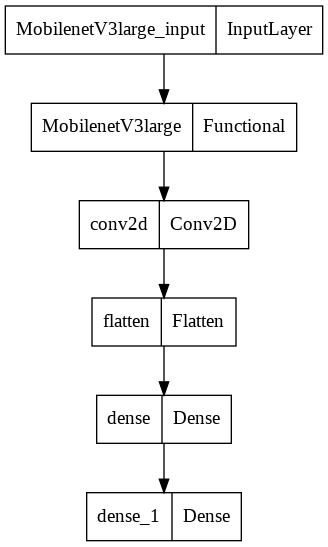

In [13]:
mobileNet_model = tf.keras.applications.MobileNetV3Large(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = None,
    input_shape = (IMG_DIMS, IMG_DIMS, 3), 
    pooling = None, 
)
print("Number of layers in the base model: ", len(mobileNet_model.layers))

mobileNet_model.trainable = True

set_trainable = ['Conv_1', 'expanded_conv_14/project', 'expanded_conv_14/squeeze_excite/Conv_1']
for layer in mobileNet_model.layers:
    if layer.name in set_trainable:
      layer.trainable =  True
    else:
      layer.trainable = False

mn_model = tf.keras.Sequential([
  mobileNet_model,
  layers.Conv2D(64, (3, 3), activation = 'relu'),
  layers.Flatten(),
  layers.Dense(100, activation = 'relu'),
  layers.Dense(NUM_CLASSES, activation = 'softmax')
])

OPTIMIZER = Adam(lr=1e-3)
mn_model.compile(optimizer=OPTIMIZER, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

mn_model.summary()
plot_model(mn_model)

In [14]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    save_freq='epoch'
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=3,
    verbose=1,
    mode='auto'
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, reduceLR]

In [15]:
history_FE = mn_model.fit(
           train_data, 
           steps_per_epoch= train_data.samples // BATCH_SIZE, 
           epochs=FE_EPOCHS,
           class_weight=class_weights,
           validation_data=test_data, 
           validation_steps=test_data.samples // BATCH_SIZE,
           callbacks=callbacks)

Epoch 1/30
652/652 [==============================] - ETA: 0s - loss: 2.1195 - accuracy: 0.5251
Epoch 1: val_loss improved from inf to 0.85812, saving model to baseline_model.h5
652/652 [==============================] - 472s 698ms/step - loss: 2.1195 - accuracy: 0.5251 - val_loss: 0.8581 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 2/30
652/652 [==============================] - ETA: 0s - loss: 1.7848 - accuracy: 0.6287
Epoch 2: val_loss improved from 0.85812 to 0.68399, saving model to baseline_model.h5
652/652 [==============================] - 418s 641ms/step - loss: 1.7848 - accuracy: 0.6287 - val_loss: 0.6840 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 3/30
652/652 [==============================] - ETA: 0s - loss: 1.5904 - accuracy: 0.6729
Epoch 3: val_loss improved from 0.68399 to 0.58387, saving model to baseline_model.h5
652/652 [==============================] - 400s 613ms/step - loss: 1.5904 - accuracy: 0.6729 - val_loss: 0.5839 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 4/30
652

Image is in CNV class
predicted class is: CNV


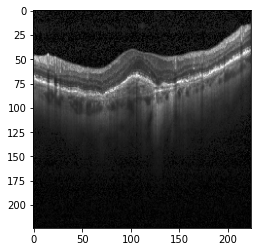

In [16]:
#VISUAL ANALYSIS 
from keras.preprocessing import image    
im1_path="/content/OCT2017/val/CNV/CNV-6668596-1.jpeg"
test_image=image.load_img(im1_path,target_size=(IMG_DIMS,IMG_DIMS))

print('Image is in CNV class')
plt.imshow(test_image)
# now to convert to 3 dimensional from 2d
test_image=image.img_to_array(test_image)
test_image= np.expand_dims(test_image,axis=0)

result=np.argmax(mn_model.predict(test_image))
print('predicted class is:', CLASSES[result])

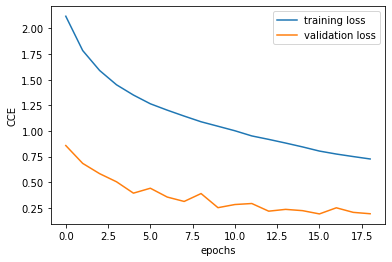

In [17]:
train_loss = history_FE.history['loss']
val_loss = history_FE.history['val_loss']

plt.plot(train_loss)
plt.plot(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')
plt.show()

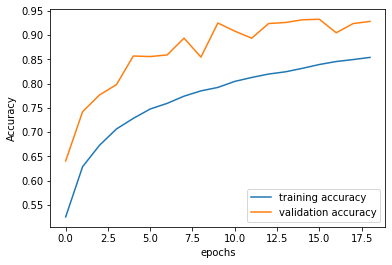

In [18]:
train_accuracy = history_FE.history['accuracy']
val_accuracy = history_FE.history['val_accuracy']

plt.plot(train_accuracy)
plt.plot(val_accuracy)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

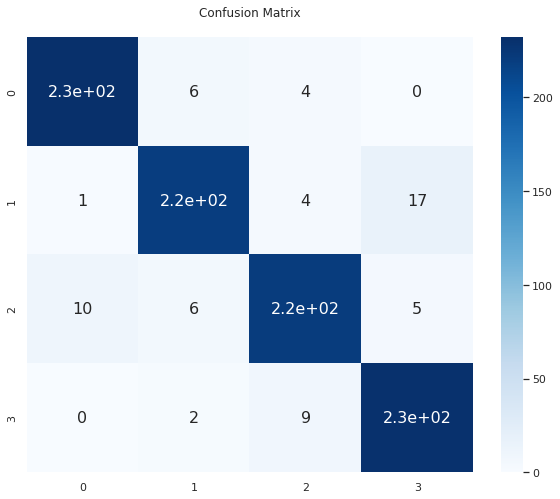

Classification Report

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       242
           1       0.94      0.91      0.92       242
           2       0.93      0.91      0.92       242
           3       0.91      0.95      0.93       242

    accuracy                           0.93       968
   macro avg       0.93      0.93      0.93       968
weighted avg       0.93      0.93      0.93       968



In [20]:
import seaborn as sn
from keras.models import load_model

best_model = load_model('/content/baseline_model.h5')
Y_pred = best_model.predict(test_data, batch_size= BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_data.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_data.class_indices.keys()), list(test_data.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_data.class_indices.keys())
print(classification_report(test_data.classes, y_pred, target_names=target_names))